In [1]:
import sys
sys.path.append('../')
import os

In [2]:
BASE_DIR = '../data/historical_klines/'

### ライブラリのインストール

In [3]:
import pandas as pd
import pandas.errors
import numpy as np
from datetime import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import joblib

import pandas as pd
import json


#gmo api に必要なライブラリ
import requests
#import json
import hmac
import hashlib
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta

#自作モジュール
from kumo_library.gmo_api.gmo_api import GmoApi_private

In [4]:
with open('../secrets.json') as f:
    secrets = json.load(f)

apiKey    = secrets["gmo_api_key"]
secretKey = secrets["gmo_api_secret"]

gmo_api_private = GmoApi_private(apiKey, secretKey)

BASE_DIR = '../data/historical_klines/'

### パラメータの指定

In [5]:
#パラメータの指定

symbols = [
    'ADA',
    'ASTR',
    'ATOM',
    'BAT',
    'BCH',
    'BTC',
    'DAI',
    'DOT',
    'ENJ',
    'ETH',
    'FCR',
    'LINK',
    'LTC',
    'MKR',
    'MONA',
    'OMG',
    'QTUM',
    'XEM',
    'XLM',
    'XRP',
    'XTZ',
    'XYM',
]
    
interval = '5min'

long_theta = 0.4
short_theta = 0.3

### データの保存

In [6]:
str_date = pd.to_datetime(datetime.now().date().strftime('%Y%m%d')) - relativedelta(days = 1)
end_date = pd.to_datetime(datetime.now().date().strftime('%Y%m%d'))
now_date = str_date
while (now_date <= end_date):
    print(now_date)
    for symbol in symbols:
        klines = gmo_api_private.GmoApi_public.get_klines(symbol=symbol, interval=interval, date=now_date.strftime('%Y%m%d'))['data']
        save_dir = f'{BASE_DIR}{interval}/{symbol}/'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        pd.DataFrame(klines).to_csv(f"{save_dir}{symbol}_{interval}_{now_date.strftime('%Y%m%d')}.csv", index=False)
    now_date = now_date + relativedelta(days = 1)

2023-07-20 00:00:00
2023-07-21 00:00:00


### データの読み込み

In [7]:
use_str_date = pd.to_datetime(datetime.now().date().strftime('%Y%m%d')) - relativedelta(days = 1)
use_end_date = pd.to_datetime(datetime.now().date().strftime('%Y%m%d'))

In [8]:
df = pd.DataFrame()

for symbol in symbols:
    for date in pd.date_range(start=use_str_date, end=use_end_date):
        try:
            temp_df = pd.read_csv(f'{BASE_DIR}{interval}/{symbol}/{symbol}_{interval}_{date.strftime("%Y%m%d")}.csv')
            temp_df['symbol'] = symbol  # Add a new column to store symbol name
            df = pd.concat([df, temp_df], axis=0)
        except (FileNotFoundError, pd.errors.EmptyDataError):
            print(f'File {BASE_DIR}{interval}/{symbol}/{symbol}_{interval}_{date.strftime("%Y%m%d")}.csv not found or empty. Skipping...')

# Assuming df is your dataframe and 'openTime' is your column with the date
df['openTime'] = pd.to_datetime(df['openTime'], unit='ms')  # convert from UNIX timestamp, if necessary
df["datetime_f"] = df['openTime'] 
df["symbol_f"] = df['symbol']

# Convert 'symbol' and 'openTime' columns to index, creating a MultiIndex
df.set_index(['openTime', 'symbol'], inplace=True)


File ../data/historical_klines/5min/DAI/DAI_5min_20230721.csv not found or empty. Skipping...


### 特徴量の計算

In [9]:
def cal_technical_f(df):
    df = df.copy()
    #移動平均からの乖離率
    for i in [5, 20]:
        df[f"{i}sma_d_rate"] = df.groupby("symbol")["close"].transform(lambda x: x/(x.rolling(i).mean()) - 1)
    #直近のリターン
    df["past_1return"] = df.groupby("symbol")["close"].transform(lambda x: x/x.shift(1) - 1)
    #高値と安値の差額を終値で除した値
    df["h_l_by_c"] = (df["high"] - df["low"])/df["close"]
    #始値と終値の差を終値で除した値
    df["c_o_by_c"] = (df["close"] - df["open"])/df["close"]
    return df

def cal_category_f(df):
    df = df.copy()
    #日付情報を分割
    df["month"] = df["datetime_f"].dt.month
    df["day"] = df["datetime_f"].dt.day
    df["hour"] = df["datetime_f"].dt.hour
    df["week"] = df["datetime_f"].dt.dayofweek #曜日
    return df

def cal_target(df):
    df.loc[:, "return"] = df.groupby("symbol")["close"].transform(lambda x: x.shift(-1)/x - 1)
    df.loc[:, "return_rank"] = df.groupby("openTime")["return"].transform(lambda x: x.rank(method = "min"))
    return df

df = cal_technical_f(df)
df = cal_category_f(df)
df = cal_target(df)

In [10]:
f_list = [
    #"open",
    #"close",
    #"high",
    #"low",
    "volume", #注文現物通貨量
    #"q_volume", #注文引用通貨量
    #"n_trades",
    #"taker_vol", #成行注文現物通貨量
    #"taker_q_vol", #成行注文引用通貨量
    #テクニカル特徴量
    "5sma_d_rate",
    "20sma_d_rate",
    #"75sma_d_rate",
    #"200sma_d_rate",
    "past_1return",
    "h_l_by_c",
    "c_o_by_c",
    #"taker_r",
    #"taker_q_r", 
    #"vol_by_trade",
    #カテゴリ変数
    "symbol_f",
    #"month",
    #"day",
    "hour",
    #"week",
]

target = "return_rank"

In [11]:
#ラベルエンコーディング
le = LabelEncoder()
df['symbol_f'] = le.fit_transform(df['symbol_f'])

### モデルの読み込み

In [12]:
ranker = joblib.load('./ranker_model.pkl')

### 予測

In [13]:
df.loc[:,"predict_value"] = ranker.predict(df[f_list]).copy()
df["predict_rank"] = df.groupby("openTime")["predict_value"].transform(lambda x: x.rank(method = "min"))

In [14]:
df.sort_index(level = 'openTime')

open         high          low   
openTime            symbol                                          
2023-07-19 21:00:00 ADA          44.896       45.000       44.800  \
                    ASTR          6.002        6.002        5.902   
                    ATOM       1290.000     1290.000     1286.000   
                    BAT          28.104       28.104       28.104   
                    BCH       34030.000    34030.000    33922.000   
...                                 ...          ...          ...   
2023-07-20 23:35:00 XYM           4.101        4.101        4.090   
2023-07-20 23:40:00 BTC     4180251.000  4182000.000  4180251.000   
                    ETH      265290.000   265290.000   265233.000   
                    LINK       1164.000     1164.000     1164.000   
                    XRP         111.300      111.300      111.300   

                                  close      volume          datetime_f   
openTime            symbol                                                
2023-07-19 21:00:00 ADA          44.800    620.0000 2023-07-19 21:00:00  \
                    ASTR          5.960  38060.0000 2023-07-19 21:00:00   
                    ATOM       1286.000     11.6000 2023-07-19 21:00:00   
                    BAT          28.104      5.0000 2023-07-19 21:00:00   
                    BCH       33956.000     90.7850 2023-07-19 21:00:00   
...                                 ...         ...                 ...   
2023-07-20 23:35:00 XYM           4.090   3000.0000 2023-07-20 23:35:00   
2023-07-20 23:40:00 BTC     4180690.000      0.0266 2023-07-20 23:40:00   
                    ETH      265233.000      0.4444 2023-07-20 23:40:00   
                    LINK       1164.000     30.0000 2023-07-20 23:40:00   
                    XRP         111.300     24.0000 2023-07-20 23:40:00   

                            symbol_f  5sma_d_rate  20sma_d_rate  past_1return   
openTime            symbol                                                      
2023-07-19 21:00:00 ADA            0          NaN           NaN           NaN  \
                    ASTR           1          NaN           NaN           NaN   
                    ATOM           2          NaN           NaN           NaN   
                    BAT            3          NaN           NaN           NaN   
                    BCH            4          NaN           NaN           NaN   
...                              ...          ...           ...           ...   
2023-07-20 23:35:00 XYM           21    -0.005205     -0.005120     -0.008244   
2023-07-20 23:40:00 BTC            5    -0.000236     -0.000849     -0.000014   
                    ETH            9    -0.000314     -0.002105     -0.000268   
                    LINK          11     0.007792      0.013584      0.000000   
                    XRP           19    -0.000659     -0.005578      0.002694   

                            h_l_by_c  c_o_by_c  month  day  hour  week   
openTime            symbol                                               
2023-07-19 21:00:00 ADA     0.004464 -0.002143      7   19    21     2  \
                    ASTR    0.016779 -0.007047      7   19    21     2   
                    ATOM    0.003110 -0.003110      7   19    21     2   
                    BAT     0.000000  0.000000      7   19    21     2   
                    BCH     0.003181 -0.002179      7   19    21     2   
...                              ...       ...    ...  ...   ...   ...   
2023-07-20 23:35:00 XYM     0.002689 -0.002689      7   20    23     3   
2023-07-20 23:40:00 BTC     0.000418  0.000105      7   20    23     3   
                    ETH     0.000215 -0.000215      7   20    23     3   
                    LINK    0.000000  0.000000      7   20    23     3   
                    XRP     0.000000  0.000000      7   20    23     3   

                              return  return_rank  predict_value  predict_rank  
openTime            symbol                                     

### 可視化

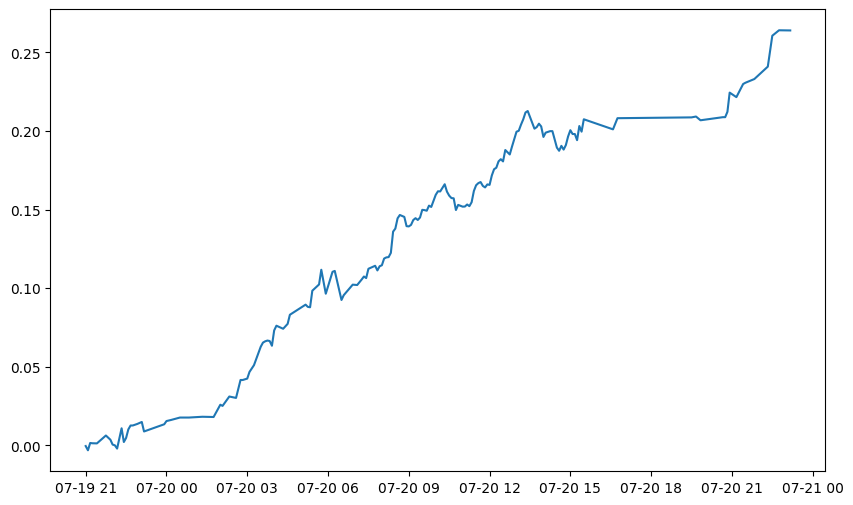

In [15]:
plt.figure(figsize=(10,6))
plt.plot(df.loc[df["predict_rank"] > int(len(symbols)*long_theta)].groupby(level = "openTime")["return"].mean().cumsum())

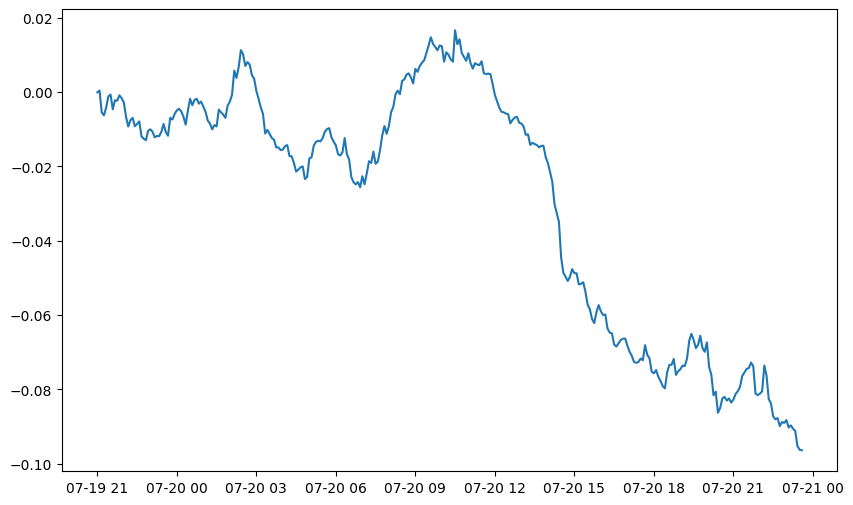

In [16]:
plt.figure(figsize=(10,6))
plt.plot(df.loc[df["predict_rank"] <= int(len(symbols)*short_theta)].groupby(level = "openTime")["return"].mean().cumsum())

### ロングリスト・ショートリストの作成

In [17]:
now_df = list(df.groupby(level='openTime'))[-1][1]
long_list = now_df.loc[df["predict_rank"] > int(len(symbols)*long_theta)].index.get_level_values('symbol').to_list()
short_list = now_df.loc[df["predict_rank"] <= int(len(symbols)*short_theta)].index.get_level_values('symbol').to_list()

In [18]:
print(long_list)
print(short_list)

[]
['BTC', 'ETH', 'LINK', 'XRP']


### ポジション取得

#### 資産残高を取得

In [19]:
position_df = pd.DataFrame(gmo_api_private.get_balance()['data'])
position_df[['amount', 'available', 'conversionRate']] = position_df[['amount', 'available', 'conversionRate']].astype(float)
position_df

,amount,available,conversionRate,symbol
0,66298.0000,66298.0000,1.000,JPY
1,0.0074,0.0074,4066257.000,BTC
2,0.0700,0.0700,258084.000,ETH
3,0.0000,0.0000,33323.000,BCH
4,0.0000,0.0000,12595.000,LTC
5,75.0000,75.0000,108.222,XRP
6,0.0000,0.0000,3.981,XEM
7,0.0000,0.0000,21.966,XLM
8,0.0000,0.0000,26.782,BAT
9,0.0000,0.0000,83.690,OMG


In [20]:
available_list = position_df.loc[position_df['available']*position_df['conversionRate'] > 100]['symbol'].tolist()
available_list.remove('JPY') if 'JPY' in available_list else available_list
available_list


['BTC', 'ETH', 'XRP']

### 未約定注文のキャンセル

In [21]:
#for symbol in symbols:
gmo_api_private.cancel_all_orders(symbols=symbols)
    

{'status': 0, 'data': [], 'responsetime': '2023-07-20T23:42:36.704Z'}

#### 発注アルゴリズム

- long_listの中にavailable_listの中の銘柄がある場合新規発注を行わない 
- short_listの中にavailable_listの中の銘柄がない場合は新規発注を行わない
- long_listの中にavailable_listの中の銘柄がない場合新規発注を行う．1000円分 
- short_listの中にavailable_listの中の銘柄がある場合は新規発注を行う．1000円分

In [22]:
rule_df = pd.DataFrame(gmo_api_private.GmoApi_public.get_rules()['data']) 
#display(rule_df)

#注文を行う関数
def round_to_tick_size(number, tick_size):
    if tick_size == 1:
        return round(number)
    else:
        return round(number / tick_size) * tick_size
    
def order_by_symbol(symbol, side, lot):
    last_price = df[df.index.get_level_values('symbol') == symbol]['close'].tail(1).values[0]
    tick_size = float(rule_df[rule_df['symbol'] == symbol]['tickSize'].values[0])

    limit_price = None  # 初期化

    if side == 'SELL':
        limit_price = round_to_tick_size(last_price + 10*tick_size, tick_size)
    elif side == 'BUY':
        limit_price = round_to_tick_size(last_price - 10*tick_size, tick_size)

    print(limit_price)

    # 初期化後、limit_price が None のままである場合、エラーメッセージを表示または適切な値を設定することも可能です。
    if limit_price is None:
        print("Error: limit_price is not set. Please check the 'side' value.")
        return

    gmo_api_private.post_order_by_JPY(symbol, side, 'LIMIT', lot, price=limit_price)



In [23]:
rule_df

,symbol,minOrderSize,maxOrderSize,sizeStep,tickSize,takerFee,makerFee
0,BTC,0.0001,5,0.0001,1,0.0005,-0.0001
1,ETH,0.01,100,0.0001,1,0.0005,-0.0001
2,BCH,0.01,100,0.001,1,0.0009,-0.0003
3,LTC,0.1,500,0.01,1,0.0009,-0.0003
4,XRP,1,100000,1,0.001,0.0005,-0.0001
5,XEM,1,50000,1,0.001,0.0009,-0.0003
6,XLM,1,50000,1,0.001,0.0009,-0.0003
7,BAT,1,20000,1,0.001,0.0009,-0.0003
8,OMG,0.1,3000,0.1,0.001,0.0009,-0.0003
9,XTZ,0.1,5000,0.1,0.001,0.0009,-0.0003


### 買い注文

In [24]:
for symbol in long_list:
    if ~(symbol in available_list):
        print(symbol)
        #order_by_symbol(symbol, 'BUY', 1000)

### 売り注文

In [25]:
for symbol in short_list:
    if symbol in available_list:
        print(symbol)
        #order_by_symbol(symbol, 'SELL', 1000)

BTC
ETH
XRP
